In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy import stats
from scipy.stats import sem
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from pylab import show, figure
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
from matplotlib.lines import Line2D
# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from scipy.ndimage import gaussian_filter
from statsmodels.formula.api import ols

from landlab.utils.flow__distance import calculate_flow__distance
from landlab.utils import watershed
from scipy.odr import *

In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    nodes = gh_nodes
    x_axis_length = gn.shape[1]
    for i in nodes:
        row = int(np.floor(i / x_axis_length))
        col = int(i - (row*x_axis_length))
        area = area_grid[row,col]
        area_dict[i] = area
    return area_dict
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def findGullyHeadNode(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node, contributing_fraction, required_ca):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if np.amax(grid_cell_receiver_nodes) < contributing_fraction or node_ca < required_ca:
                # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
                # is no suitable grid cell (node).
                if j == distance_from_node - 1:
                    catchment_area_dict[i] = 'No grid cell found'
                else:
                    # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                    # in the next iteration.
                    index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                    next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, catchment_outlet_ids, 
                         step_size_m, comparison_distance_m, change_detection_factor, slope_above_head):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    upslope_divergence_dict = {}
    slope_dict = {}
    slope_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                    
        area_along_central_drainage_line = []
        for key, value in node_area_dict.items():
            area_along_central_drainage_line.append(value)
        median_area_along_central_drainage_line = ndimage.median_filter(area_along_central_drainage_line, size=step_size_m)
        slope_along_central_drainage_line = []
        for key, value in slope_mean_dict.items():
            slope_along_central_drainage_line.append(value)
        slope_mean_above_gully = np.mean(np.array(slope_along_central_drainage_line))
        slope_dict[i] = slope_mean_above_gully
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_area_along_central_drainage_line) < required_number_of_grid_cells:
            upslope_divergence_dict[i] = 'not enough grid cells'
        else:
            divergence_occuring = upslopeDivergence(median_area_along_central_drainage_line, change_detection_factor, 
                                                    step_size, comparison_distance)
            upslope_divergence_dict[i] = divergence_occuring
            
    return upslope_divergence_dict, slope_dict, slope_at_head
def thresholdLineOnlyCooks(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)
    if len(regression_dataset) < 3:
        corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        m = ols('log_slope ~ log_area',regression_dataset).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            corrected_set = regression_dataset.drop(high_value_list, axis='index')
        else:
            corrected_set = regression_dataset
            
    return corrected_set

In [3]:
input_DEM_resolution = 1

location = (r'C:\PhD\manuscript\flow_routing_algorithms\data\fill_and_breach_dems')
os.chdir(location)

input_geotiff = gdal.Open('fann_sub_3.tif')
input_DEM = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

gully_head_layer = gdal.Open('fann_sub_3_gh.tif')
gh = np.array(gully_head_layer.GetRasterBand(1).ReadAsArray()).astype('uint8')

input_ca_grid = gdal.Open('fann_sub_3_m8.tif')
ca_grid = np.array(input_ca_grid.GetRasterBand(1).ReadAsArray())

In [4]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [5]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();

In [6]:
filled_dem = z1.reshape(mg.shape)

In [7]:
sinks =  filled_dem - input_DEM 

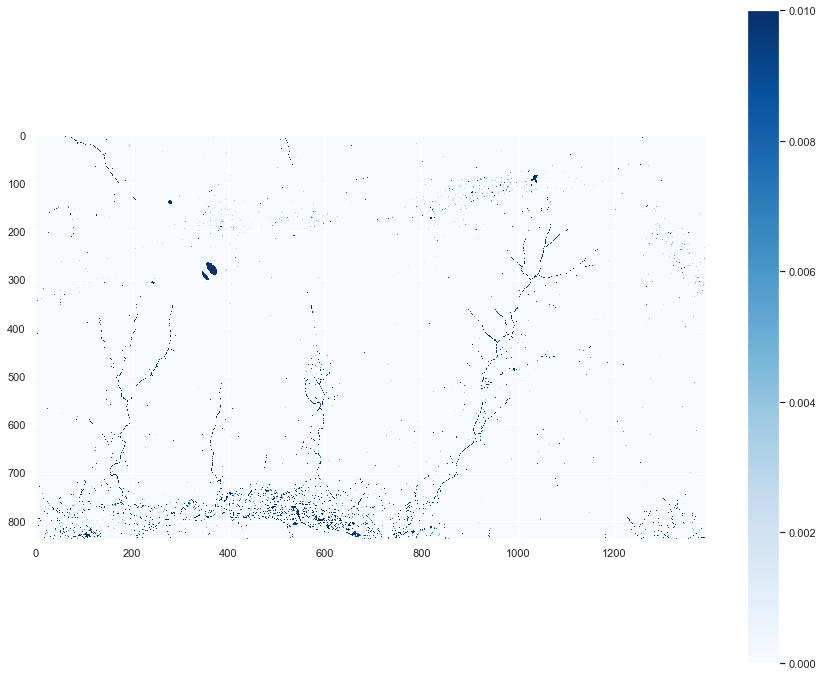

In [8]:
plt.figure(figsize = (15,12))
plt.imshow(sinks, cmap="Blues", vmax = 0.01);
plt.colorbar();

In [9]:
sinks[sinks>0]=1
np.sum(sinks)

19411.0

In [10]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))

In [11]:
grid_nodes_float = grid_nodes.astype('float64')

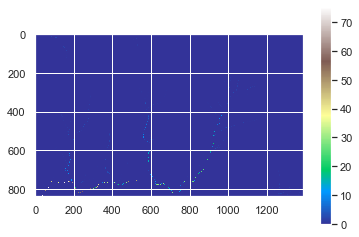

In [12]:
plt.imshow(ca_grid, cmap="terrain");
plt.colorbar();

## Isolate all gully head nodes

In [13]:
find_nodes = np.multiply(gh, grid_nodes);

## Create array of only gully head nodes 

In [14]:
gh_array = np.unique(find_nodes);

## Turn gully head node array into a list and remove the value 0

In [15]:
gh_list = gh_array.tolist();
gh_list.remove(0);

In [16]:
len(gh_list)

33

## Work through list finding index positions of each node

In [17]:
catchment_area_dict, catchment_area_node_list = findGullyHeadNode(gh_list, grid_nodes, input_DEM, ca_grid,
                                                                  input_DEM_resolution, 10, 0.9, 0.25)                                                                                            

max ca:  0.72895522
Node id:  220 Catchment area:  0.30602284
Node id:  199 Catchment area:  0.60644443
max ca:  1.37504849
Node id:  220 Catchment area:  0.24569247
Node id:  200 Catchment area:  0.2307672
Node id:  179 Catchment area:  0.23085998
Node id:  158 Catchment area:  0.28292664
max ca:  1.07093324
Node id:  220 Catchment area:  0.89212995
max ca:  1.77514908
Node id:  220 Catchment area:  0.14129187
Node id:  198 Catchment area:  0.52312393
Node id:  176 Catchment area:  0.68526293
max ca:  0.51561054
Node id:  220 Catchment area:  0.43809068
max ca:  0.32445397
Node id:  220 Catchment area:  0.27163086
Node id:  241 Catchment area:  0.26203508
max ca:  0.71422452
Node id:  220 Catchment area:  0.27530378
max ca:  0.50803781
Node id:  220 Catchment area:  0.25933168
Node id:  240 Catchment area:  0.19070128
Node id:  261 Catchment area:  0.18364226
Node id:  281 Catchment area:  0.2244313
Node id:  301 Catchment area:  0.26367756
Node id:  321 Catchment area:  0.29070476
No

In [18]:
len(catchment_area_node_list)

32

In [19]:
outlet_ids = np.isin(grid_nodes,catchment_area_node_list).astype('uint8')

In [343]:
input_barnes_1 = gdal.Open('fs_3_fd8_0_5_fps.tif')
fd8_1 = np.array(input_barnes_1.GetRasterBand(1).ReadAsArray())/10000

input_barnes_1_1 = gdal.Open('fs_3_fd8_1_fps.tif')
fd8_1_1 = np.array(input_barnes_1_1.GetRasterBand(1).ReadAsArray())/10000

input_barnes_1_5 = gdal.Open('fs_3_fd8_1_1_fps.tif')
fd8_1_5 = np.array(input_barnes_1_5.GetRasterBand(1).ReadAsArray())/10000

input_barnes_5 = gdal.Open('fs_3_fd8_1_5_fps.tif')
fd8_5 = np.array(input_barnes_5.GetRasterBand(1).ReadAsArray())/10000

input_barnes_10 = gdal.Open('fs_3_fd8_2_fps.tif')
fd8_10 = np.array(input_barnes_10.GetRasterBand(1).ReadAsArray())/10000

input_barnes_20 = gdal.Open('fs_3_fd8_5_fps.tif')
fd8_20 = np.array(input_barnes_20.GetRasterBand(1).ReadAsArray())/10000

input_barnes_30 = gdal.Open('fs_3_fd8_10_fps.tif')
fd8_30 = np.array(input_barnes_30.GetRasterBand(1).ReadAsArray())/10000


In [344]:
fd8_1_dict = catchmentDicts(fd8_1, grid_nodes, catchment_area_node_list)
fd8_1_1_dict = catchmentDicts(fd8_1_1, grid_nodes, catchment_area_node_list)
fd8_1_5_dict = catchmentDicts(fd8_1_5, grid_nodes, catchment_area_node_list)
fd8_5_dict = catchmentDicts(fd8_5, grid_nodes, catchment_area_node_list)
fd8_10_dict = catchmentDicts(fd8_10, grid_nodes, catchment_area_node_list)
fd8_20_dict = catchmentDicts(fd8_20, grid_nodes, catchment_area_node_list)
fd8_30_dict = catchmentDicts(fd8_30, grid_nodes, catchment_area_node_list)

In [345]:
ds = [fd8_1_dict, fd8_1_1_dict, fd8_1_5_dict, fd8_5_dict, fd8_10_dict,fd8_20_dict,fd8_30_dict]
d = {}
for k in fd8_1_dict.keys():
    d[k] = tuple(d[k] for d in ds)

In [346]:
catchment_areas = pd.DataFrame.from_dict(d, orient='index')

In [347]:
catchment_areas.rename(columns={0: 'fd8_1', 1: 'fd8_1_1', 2: 'fd8_1_5', 
                                3: 'fd8_5', 4: 'fd8_10', 5: 'fd8_20', 6: 'fd8_30'}, inplace=True)

In [348]:
node_id_column = np.array(catchment_areas.index)

In [349]:
catchment_areas['node_id'] = node_id_column

In [350]:
catchment_areas.head()

,fd8_1,fd8_1_1,fd8_1_5,fd8_5,fd8_10,fd8_20,fd8_30,node_id
44923,0.329092,0.371702,0.377801,0.393905,0.392841,0.170695,0.037868,44923
74090,0.309549,0.292795,0.290166,0.278217,0.259962,0.266000,0.155042,74090
82422,0.483070,0.545455,0.558870,0.615543,0.691230,1.012950,1.269693,82422
136196,0.458657,0.476231,0.477882,0.480056,0.475441,0.398437,0.316106,136196
202814,0.273272,0.263510,0.261782,0.255039,0.245908,0.192084,0.189848,202814


In [351]:
divergence_dict, slope_dict, slope_area_data = upstreamDrainageLine(100, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area_node_list, 5, 5, 0.5, 10)

10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10
10   10


In [352]:
len(slope_area_data)

32

In [353]:
upstream_divergence = pd.DataFrame.from_dict(divergence_dict, orient='index')

In [354]:
upstream_divergence.columns = ['DC']

In [355]:
slope_area_dataframe = pd.DataFrame.from_dict(slope_area_data, orient='index')

In [356]:
slope_area_dataframe.rename(columns={0: 'SA', 1: 'node_id'}, inplace=True)

In [357]:
slope_area_dataframe

,SA,node_id
44923,0.061763,44923
74090,0.038220,74090
82422,0.055444,82422
136196,0.045901,136196
202814,0.058907,202814
245356,0.052227,245356
262017,0.039869,262017
270376,0.105330,270376
320216,0.063087,320216
325963,0.044770,325963


In [358]:
mean_slope = pd.DataFrame.from_dict(slope_dict, orient='index')

In [359]:
mean_slope.columns = ['Slope']

In [360]:
merge_all = pd.concat([catchment_areas, upstream_divergence, mean_slope, slope_area_dataframe], axis=1, sort=False)

In [361]:
merge_all['Resolution'] = input_DEM_resolution

In [362]:
all_data_1m = merge_all

In [363]:
convergent_gullies = all_data_1m.loc[all_data_1m['DC'] == 0]

In [364]:
divergent_gullies = all_data_1m.loc[all_data_1m['DC'] == 1]

In [365]:
convergent_gullies['Flow'] = convergent_gullies.count()[0]

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [366]:
divergent_gullies['Flow'] = divergent_gullies.count()[0]

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [367]:
gully_types = [divergent_gullies, convergent_gullies]

In [368]:
data_with_counts = pd.concat(gully_types)

In [369]:
all_data_1m_dataframe = data_with_counts.loc[:,~data_with_counts.columns.duplicated()]

In [370]:
c = all_data_1m_dataframe.loc[all_data_1m_dataframe['DC'] == 0]

In [371]:
c_id = np.array(c['node_id'])
c_list = c_id.tolist()

In [372]:
d = all_data_1m_dataframe.loc[all_data_1m_dataframe['DC'] == 1]

In [373]:
d_id = np.array(d['node_id'])
d_list = d_id.tolist()

In [374]:
all_data_1m_dataframe

,fd8_1,fd8_1_1,fd8_1_5,fd8_5,fd8_10,fd8_20,fd8_30,node_id,DC,Slope,SA,Resolution,Flow
44923,0.329092,0.371702,0.377801,0.393905,0.392841,0.170695,0.037868,44923,1,0.037145,0.061763,1,17
82422,0.483070,0.545455,0.558870,0.615543,0.691230,1.012950,1.269693,82422,1,0.038900,0.055444,1,17
136196,0.458657,0.476231,0.477882,0.480056,0.475441,0.398437,0.316106,136196,1,0.063849,0.045901,1,17
245356,0.279543,0.288341,0.289443,0.292537,0.295528,0.298721,0.262867,245356,1,0.039216,0.052227,1,17
262017,0.409922,0.369842,0.362462,0.335979,0.309525,0.234010,0.216305,262017,1,0.057573,0.039869,1,17
320216,0.387212,0.409557,0.414095,0.431693,0.450382,0.480327,0.361414,320216,1,0.033140,0.063087,1,17
610481,0.241210,0.290889,0.298094,0.313437,0.301190,0.105549,0.026914,610481,1,0.034256,0.066192,1,17
698722,2.093269,2.535666,2.615444,2.919652,3.277531,4.534229,5.096706,698722,1,0.051489,0.021679,1,17
705666,0.000332,0.000277,0.000275,0.000271,0.000268,0.000279,0.000295,705666,1,0.048223,0.024941,1,17
715205,1.886775,1.992079,1.996523,1.988290,1.947600,1.721289,1.679940,715205,1,0.050359,0.032530,1,17


In [375]:
data_to_plot = all_data_1m_dataframe

In [410]:
slope_to_use = 'SA'
area_to_use = 'fd8_5'

In [411]:
data_to_plot['log_area'] = np.log10(data_to_plot[area_to_use])
data_to_plot['log_slope'] = np.log10(data_to_plot[slope_to_use])

No handles with labels found to put in legend.


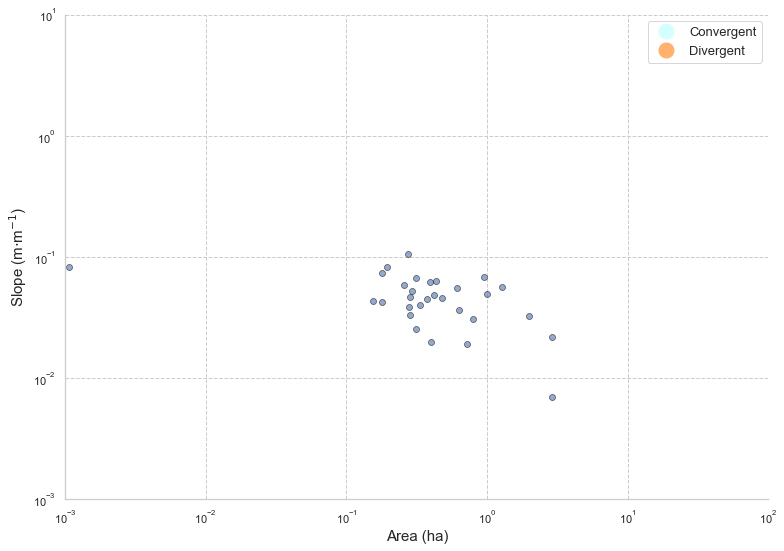

In [412]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_to_plot
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = area_to_use
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [413]:
data_used_by_model = thresholdLineOnlyCooks(data_to_plot, area_to_use, slope_to_use)
data_used_by_model2 = thresholdLineOnlyCooks(data_used_by_model, area_to_use, slope_to_use)

No handles with labels found to put in legend.


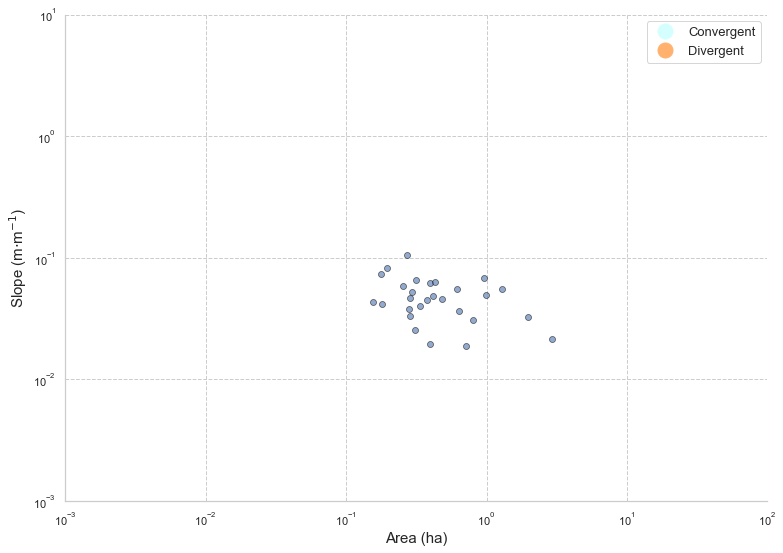

In [414]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_used_by_model2
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = area_to_use
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [415]:
orthogonal_regression_dataset = data_to_plot

In [416]:
# Initiate some data, giving some randomness using random.random().
x = orthogonal_regression_dataset.loc[:,'log_area'].values
y = orthogonal_regression_dataset.loc[:,'log_slope'].values

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
   
# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-0.4, -1])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [-0.09757278 -1.41949818]
Beta Std Error: [ 0.04501836  0.04967229]
Beta Covariance: [[ 0.03699594  0.02234246]
 [ 0.02234246  0.0450405 ]]
Residual Variance: 0.05478039508260677
Inverse Condition #: 0.4844857698810467
Reason(s) for Halting:
  Sum of squares convergence


In [417]:
print('b: ', out.beta[0] *-1)
print('k: ', 10**out.beta[1])

b:  0.0975727848177
k:  0.0380628949001


In [418]:
b_orth = out.beta[0] 
k_orth = out.beta[1]

In [419]:
k_adjustment_dataset = data_to_plot

In [420]:
proportion_of_points_above_line = 0.9
target_number_of_points_above_line = np.ceil(len(k_adjustment_dataset)*proportion_of_points_above_line).astype(int)
adjustment = 0
for u in range(0,100):
    above_model_line = []
    for j in k_adjustment_dataset.index:
        measured_slope = k_adjustment_dataset['log_slope'].loc[j]
        adjusted_intercept = k_orth - adjustment
        model_slope = b_orth * k_adjustment_dataset['log_area'].loc[j] + adjusted_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)                
        else:
            pass
    if len(above_model_line) >= target_number_of_points_above_line:
        break
    else:
        adjustment += 0.01
                

#corrected_set = regression_dataset.drop(above_model_line, axis='index')

In [421]:
exponent_b_to_use = b_orth*-1
scalar_k_to_use = 10**adjusted_intercept

In [422]:
graph_data = data_to_plot

In [423]:
model_parameter_k = scalar_k_to_use
model_parameter_b = exponent_b_to_use

In [424]:
generate_area_values = np.arange(0.01, 10, 0.0001)
model_slope = model_parameter_k * (generate_area_values**-model_parameter_b )
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: area_to_use}, inplace=True)
#graph_data['DC'] = 1
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: slope_to_use}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3
graph_data['Size'] = 500
df_model['Size'] = 1

df_all_1 = df_model.append(graph_data)

In [425]:
pd.set_option('display.max_rows', 100)

No handles with labels found to put in legend.


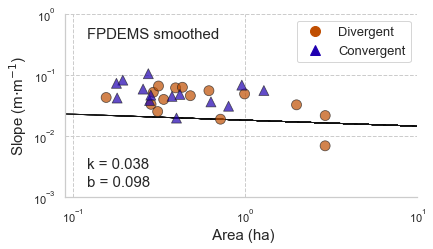

In [426]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_1
colours = {0:'xkcd:ultramarine', 3:'xkcd:black', 1:'xkcd:burnt orange'}
x_axis = area_to_use
#x_axis_label = x_axis + ' Area (ha)'
x_axis_label = ' Area (ha)'
y_axis = slope_to_use
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.7, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^', 'o', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.09, 10))
fig.set(ylim = (0.001, 1))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

g1 = Line2D([], [], color='xkcd:burnt orange', marker='o', linestyle='None',
                         markersize=10, label='Divergent')

g2 = Line2D([], [], color='xkcd:ultramarine', marker='^', linestyle='None',
                          markersize=10, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[g1, g2],fontsize=13, loc=1)
#plt.legend(handles=[g1],fontsize=13, loc=1)

ax.text(0.12, 0.4,'FPDEMS smoothed', fontsize=15) 
ax.text(0.12, 0.003,'k = ' + str(np.round(10**out.beta[1], 3)), fontsize=15) 
ax.text(0.12, 0.0015,'b = ' + str(np.round(model_parameter_b, 3)), fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(6,3)

## Setup regression training data taking the log10 of x and y so that a simple linear regression can be used to estimate the parameters k and a. 

## Bootstrap regression (one iteration but can be changed to two).

In [ ]:
slope_area_montecarlo_dict = {}
method = 'M8'
gully_ids = np.array(d['node_id'])
gully_head_list = gully_ids.tolist()
sample_size = 30
whole_dataset = all_data_1m_dataframe
cooks_d_cutoff = 4 / sample_size

for i in range(0,10000):
    sample_number = 'Sample' + str(i)
    all_gully_sample = random.sample(gully_head_list, sample_size)
    all_sample_gullies = pd.DataFrame(all_gully_sample) 
    all_sample_gullies.rename(columns={0: 'node_id'}, inplace=True)
    
    all_gully_sample_set = pd.merge(all_sample_gullies, whole_dataset, on=['node_id'], how='inner')
    all_gully_sample_set['log_area'] = np.log10(all_gully_sample_set[method])
    all_gully_sample_set['log_slope'] = np.log10(all_gully_sample_set['SA'])

    m = ols('log_area ~ log_slope',all_gully_sample_set).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]
            
    above_model_line = []
    for j in range(0, len(all_gully_sample_set)):
        measured_slope = all_gully_sample_set['log_slope'].iloc[j]
        model_slope = r_slope * all_gully_sample_set['log_area'].iloc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass
    
    corrected_set = all_gully_sample_set.drop(above_model_line, axis='index')
 
    if len(corrected_set) < 3:
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()
        
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            print(sample_number)

            slope_area_montecarlo_dict[sample_number] = ([slope, intercept])

In [ ]:
div_curve = pd.DataFrame.from_dict(slope_area_montecarlo_dict, orient='index')

In [ ]:
div_k_exclusion = []
for index, row in div_curve.iterrows():
    if row[1] > 1:
        print('index: ',index, 'value: ', (row[1]))
        div_k_exclusion.append(index)

div_b_exclusion = []
for index, row in div_curve.iterrows():
    if row[0] > 1:
        print('index: ',index, 'value: ', (row[0]))
        div_b_exclusion.append(index)

In [ ]:
corrected_div_k = div_curve[1].drop(div_k_exclusion, axis='index')
corrected_div_b = div_curve[0].drop(div_b_exclusion, axis='index')

In [ ]:
mean_div = np.round(np.mean(div_curve[0]),5)
div_standard_error = np.round(sem(div_curve[0]),5)
mean_div_int = np.round(np.mean(div_curve[1]),5)
div_standard_error_int = np.round(sem(div_curve[1]),5)
standard_deviation_divergent = np.std(np.array(corrected_div_b))
standard_deviation_divergent_int = np.std(np.array(corrected_div_k))

In [ ]:
conv_curve = pd.DataFrame.from_dict(slope_area_montecarlo_dict, orient='index')

In [ ]:
conv_k_exclusion = []
for index, row in conv_curve.iterrows():
    if row[1] > 1:
        conv_k_exclusion.append(index)
        
conv_b_exclusion = []
for index, row in conv_curve.iterrows():
    if row[0] > 1:
        conv_b_exclusion.append(index)

In [ ]:
corrected_conv_k = conv_curve[1].drop(conv_k_exclusion, axis='index')
corrected_conv_b = conv_curve[0].drop(conv_b_exclusion, axis='index')

In [ ]:
mean_conv = np.round(np.mean(conv_curve[0]),5)
conv_standard_error = np.round(sem(conv_curve[0]),5)
mean_conv_int = np.round(np.mean(conv_curve[1]),5)
conv_standard_error_int = np.round(sem(conv_curve[1]),5)
standard_deviation_convergent = np.std(np.array(corrected_conv_b))
standard_deviation_convergent_int = np.std(np.array(corrected_conv_k))

In [ ]:
variance_over_df_conv_b = (np.std(np.array(conv_curve[0]))**2) / len(c_list)
variance_over_df_div_b = (np.std(np.array(div_curve[0]))**2) / len(d_list)
variance_over_df_conv_k = (np.std(np.array(conv_curve[1]))**2) / len(c_list)
variance_over_df_div_k = (np.std(np.array(div_curve[1]))**2) / len(d_list)
denominator_b = np.sqrt(variance_over_df_conv_b + variance_over_df_div_b)
denominator_k = np.sqrt(variance_over_df_conv_k + variance_over_df_div_k)
numerator_b = mean_conv - mean_div
numerator_k = mean_conv_int - mean_div_int
t_value_b = numerator_b / denominator_b
t_value_k = numerator_k / denominator_k


In [ ]:
print('div stdev b: ', standard_deviation_divergent)
print('div stdev k: ', standard_deviation_divergent_int)
print('conv stdev b: ', standard_deviation_convergent)
print('conv stdev k: ', standard_deviation_convergent_int)


In [ ]:
degrees_of_freedom = np.min([len(c_list), len(d_list)]) - 1

In [ ]:
degrees_of_freedom

In [ ]:
test_of_significance_b = t.sf(t_value_b, degrees_of_freedom) * 2
test_of_significance_k = t.sf(t_value_k, degrees_of_freedom) * 2
print('Significant difference b: ', test_of_significance_b)
print('Significant difference k: ', test_of_significance_k)

In [ ]:
if test_of_significance_b < 0.0005:
    b_significance = '(***)'
elif test_of_significance_b < 0.005:
    b_significance = '(**)'
elif test_of_significance_b < 0.05:
    b_significance = '(*)'
else:
    b_significance= '(ns)'
    

In [ ]:
if test_of_significance_k < 0.0005:
    k_significance = '(***)'
elif test_of_significance_k < 0.005:
    k_significance = '(**)'
elif test_of_significance_k < 0.05:
    k_significance = '(*)'
else:
    k_significance = '(ns)'
    

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (8, 5))
sns.distplot(corrected_conv_b, color = 'xkcd:royal blue', kde = False, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 600)
ax1.set_ylabel('Count', fontsize=20)
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 1000)
ax1.set_xlabel(str(method) + ' estimate of exponent (b)', fontsize = 20)
ax1.legend(['Convergent: $\mu$ = '+str(np.round(mean_conv,3))+' $\pm$'+str(np.round(conv_standard_error,3))],
           bbox_to_anchor=(0.5, 0.6, 0.5, 0.4),fontsize = 14)
ax1.set_xlim(-0.2, 1)
ax2 = ax1.twinx()
ax2.set_ylim(0, 1000)
ax2.set_xlim(-0.2, 1)
ax2.axes.yaxis.set_visible(False)
sns.distplot(corrected_div_b,  color='xkcd:burnt orange', kde = False,hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 600)
#ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['Divergent: $\mu$ = '+str(np.round(mean_div,3))+' $\pm$'+str(np.round(div_standard_error,3))],
           bbox_to_anchor=(0.5, 0.47, 0.5, 0.4),fontsize = 14)
plt.axvline(x=mean_div, linewidth=1, color = 'xkcd:burnt orange', alpha = 1, linestyle = '--')
plt.axvline(x=mean_conv, linewidth=1, color = 'xkcd:royal blue', alpha = 1, linestyle = '--')
ax1.text(0.59, 650, r'$H_0$: $\mu_{conv}$  $\neq$ $\mu_{div}$ ' + b_significance, fontsize=15, rotation = 0)

#plt.title('Estimate of exponent (b)', fontsize = 12)

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (8, 5))
sns.distplot(corrected_conv_k, color = 'xkcd:royal blue', kde = False, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 400)
ax1.set_ylabel('Count', fontsize=20)
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 1000)
ax1.set_xlabel(str(method) + ' estimate of threshold coefficient (k)', fontsize = 20)
ax1.legend(['Convergent: $\mu$ = '+str(np.round(mean_conv_int, 3))+' $\pm$'+str(np.round(conv_standard_error_int, 3))],
           bbox_to_anchor=(0.5, 0.6, 0.5, 0.4),fontsize = 14)
ax1.set_xlim(0, .1)
ax2 = ax1.twinx()
ax2.set_ylim(0, 1000)
ax2.set_xlim(0, .1)
ax2.axes.yaxis.set_visible(False)
sns.distplot(corrected_div_k,  color='xkcd:burnt orange', kde = False,hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.8}, bins = 900)
#ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['Divergent: $\mu$ = '+str(np.round(mean_div_int,3))+' $\pm$'+str(np.round(div_standard_error_int, 3))],
           bbox_to_anchor=(0.5, 0.47, 0.5, 0.4),fontsize = 14)
plt.axvline(x=mean_div_int, linewidth=1, color = 'xkcd:burnt orange', alpha = 1, linestyle = '--')
plt.axvline(x=mean_conv_int, linewidth=1, color = 'xkcd:royal blue', alpha = 1, linestyle = '--')
ax1.text(0.065, 650, r'$H_0$: $\mu_{conv}$  $\neq$ $\mu_{div}$ '+ k_significance, fontsize=15, rotation = 0)
#plt.title('Estimate of exponent (b)', fontsize = 12)

In [ ]:
np.round(div_standard_error_int, 4)

In [ ]:
#divergent_gully = random.choice(d_list)
divergent_gully = 62358126
divergent_gully_2 = 61694828
gully_sample = random.sample(c_list, 20)
gully_sample.append(divergent_gully)
gully_sample.append(divergent_gully_2)
sample_gullies = pd.DataFrame(gully_sample) 
sample_gullies.rename(columns={0: 'node_id'}, inplace=True)
gully_sample_set = pd.merge(sample_gullies, all_data_1m_dataframe, on=['node_id'], how='inner')


In [ ]:
gully_sample_set['DC'].iloc[21] = 2


In [ ]:
method = 'M4'

In [ ]:
gully_sample_set['log_area'] = np.log10(gully_sample_set[method])
gully_sample_set['log_slope'] = np.log10(gully_sample_set['SA'])
test_m = ols('log_slope ~ log_area',gully_sample_set).fit()
test_intercept = test_m.params[0]
test_slope = test_m.params[1]

In [ ]:
above_model_line = []
for i in range(0, len(gully_sample_set)):
    measured_slope = gully_sample_set['log_slope'].iloc[i]
    model_slope = test_slope * gully_sample_set['log_area'].iloc[i] + test_intercept
    if  measured_slope > model_slope:
        above_model_line.append(i)
    else:
        pass    

In [ ]:
corrected_set = gully_sample_set.drop(above_model_line, axis='index')

In [ ]:
lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
l_intercept = lowest_points_m.params[0]
l_slope = lowest_points_m.params[1]

In [ ]:
index_position_list = []
for index, row in corrected_set.iterrows():
    index_position_list.append(index)


In [ ]:
above_second_model_line = []
for i in range(0, len(corrected_set)):
    measured_slope = corrected_set['log_slope'].iloc[i]
    model_slope = l_slope * corrected_set['log_area'].iloc[i] + l_intercept
    if  measured_slope > model_slope:
        above_second_model_line.append(index_position_list[i])
    else:
        pass
    

In [ ]:
corrected_set_2 = corrected_set.drop(above_second_model_line, axis='index')

In [ ]:
corrected_set_2

## Write the estimated slope and intercept parameters to variables.
Note: The returned intercept will be in log10(a) form so we need to take the exponential $10^{k}$ to get back to the non-log10 value of the assumed function $s \geq kA^{-b}$.

In [ ]:
second_lowest_points_m = ols('log_slope ~ log_area',corrected_set_2).fit()
sl_intercept = second_lowest_points_m.params[0]
sl_slope = second_lowest_points_m.params[1]

In [ ]:
print('All data intercept: ', 10**test_intercept)
print('All data slope: ', test_slope * -1)

In [ ]:
print('Lowest data intercept: ', 10**l_intercept)
print('Lowest data slope: ', l_slope * -1)

In [ ]:
print('Second lowest data intercept: ', 10**sl_intercept)
print('Second lowest data slope: ', sl_slope * -1)

## Second model can either be l_slope or sl_slope.

In [ ]:
generate_area_values = np.arange(0.2, 10, 0.00001)
model_slope = (10**test_intercept) * generate_area_values**(test_slope)
model_slope_alt = (10**sl_intercept) * generate_area_values**(sl_slope)
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: method}, inplace=True)

## Reshape the slope array so we can put it into a pandas dataframe.

In [ ]:
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: 'SA'}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3

In [ ]:
reshaped_model_slope_alt = model_slope_alt.reshape(-1,1)
df_model_slope_alt = pd.DataFrame(reshaped_model_slope_alt)
df_model_slope_alt.rename(columns={0: 'SA'}, inplace=True)
df_model_alt = pd.concat([df_model_slope_alt, df_model_area], axis=1, sort=False)
df_model_alt['DC'] = 4

In [ ]:
gully_sample_set['Size'] = 1000
df_model['Size'] = 1
df_model_alt['Size'] = 1
df_all_1 = df_model.append(df_model_alt)
df_all_2 = df_all_1.append(gully_sample_set)

In [ ]:
gully_sample_set

In [ ]:
df_all_2

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_2
colours = {0:'xkcd:ultramarine', 1:'xkcd:orange', 2:'xkcd:scarlet', 3:'xkcd:black', 4:'xkcd:forest green'}
x_axis = method
x_axis_label = x_axis + ' Area (ha)'
y_axis = 'SA'
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.8, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^','s', 'o', '.', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.1, 20))
fig.set(ylim = (0.001, 0.2))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

g1 = Line2D([], [], color='xkcd:orange', marker='s', linestyle='None',
                          markersize=15, label='Gully head 1 (divergent)')

rs = Line2D([], [], color='xkcd:royal blue', marker='^', linestyle='None',
                          markersize=15, label='Random sample (convergent)')

g2 = Line2D([], [], color='xkcd:scarlet', marker='o', linestyle='None',
                          markersize=15, label='Gully head 2 (divergent)')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[rs, g1, g2],fontsize=13, loc=3)

ax.text(0.12, 0.005,'k = ' + str(np.round(10**sl_intercept, 2)), fontsize=15) 
ax.text(0.12, 0.004,'b = ' + str(np.round(sl_slope*-1, 2)), fontsize=15)  

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(5,5)

## End of this section. Below is stuff that I think is duplicated in other notebooks.

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))
g0 = sns.scatterplot(x="M8", y="SA", marker = 'x', edgecolor= 'xkcd:royal blue', legend = False, 
                     linewidth = 1,data=gsc)
g1 = sns.scatterplot(x="M8", y="SA", marker = 'o',alpha=0.4, color='xkcd:orange', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
g2 = sns.scatterplot(x="D8", y="SA", marker = 'D',alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:black', 
                     linewidth = 1, data=gsd, s = 60, legend = False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = '',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
#plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:apricot')
#ax.set_ylim(-0.1,2)
#ax.set_xlim(-0.1,2)

In [ ]:
corr_1m_divergent = all_data_1m.loc[(all_data_1m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_1m_convergent = all_data_1m.loc[(all_data_1m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_2m_divergent = all_data_2m.loc[(all_data_2m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_2m_convergent = all_data_2m.loc[(all_data_2m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_3m_divergent = all_data_3m.loc[(all_data_3m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_3m_convergent = all_data_3m.loc[(all_data_3m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_4m_divergent = all_data_4m.loc[(all_data_4m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_4m_convergent = all_data_4m.loc[(all_data_4m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

corr_5m_divergent = all_data_5m.loc[(all_data_5m['DC'] == 1)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()
corr_5m_convergent = all_data_5m.loc[(all_data_5m['DC'] == 0)].drop(columns = ['node_id', 'DC', 'Slope', 'Resolution']).corr()

In [ ]:
corr_1m_divergent

In [ ]:
corr_1m_convergent

In [ ]:
corr_2m_divergent

In [ ]:
corr_1m_convergent

In [ ]:
sns.set(style = 'ticks')

data = corr_1m_convergent

mask = np.triu(np.ones_like(data, dtype=np.bool))

comparison = sns.heatmap(data, xticklabels=data.columns, mask=mask,
                         yticklabels=data.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.5, vmax = 1, linecolor = 'white', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

In [ ]:
sns.set(style = 'ticks')

data = corr_1m_divergent

mask = np.triu(np.ones_like(data, dtype=np.bool))

comparison = sns.heatmap(data, xticklabels=data.columns, mask=mask,
                         yticklabels=data.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.5, vmax = 1, linecolor = 'white', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

In [ ]:
correlation_dict_convergent = {}
correlation_dict_divergent = {}

In [ ]:

correlation_dict_convergent['D4-M8'] = [corr_1m_convergent.iloc[4,0], 
                             corr_2m_convergent.iloc[4,0], corr_3m_convergent.iloc[4,0], 
                             corr_4m_convergent.iloc[4,0], corr_5m_convergent.iloc[4,0]]

correlation_dict_convergent['D8-M8'] = [corr_1m_convergent.iloc[4,1], 
                             corr_2m_convergent.iloc[4,1], corr_3m_convergent.iloc[4,1], 
                             corr_4m_convergent.iloc[4,1], corr_5m_convergent.iloc[4,1]]

correlation_dict_convergent['Dinf-M8'] = [corr_1m_convergent.iloc[4,2], 
                               corr_2m_convergent.iloc[4,2], corr_3m_convergent.iloc[4,2], 
                               corr_4m_convergent.iloc[4,2], corr_5m_convergent.iloc[4,2]]
correlation_dict_convergent['M4-M8'] = [corr_1m_convergent.iloc[4,3], 
                             corr_2m_convergent.iloc[4,3], corr_3m_convergent.iloc[4,3], 
                             corr_4m_convergent.iloc[4,3], corr_5m_convergent.iloc[4,3]]

correlation_dict_divergent['D4-M8'] = [corr_1m_divergent.iloc[4,0], 
                             corr_2m_divergent.iloc[4,0], corr_3m_divergent.iloc[4,0], 
                             corr_4m_divergent.iloc[4,0], corr_5m_divergent.iloc[4,0]]

correlation_dict_divergent['D8-M8'] = [corr_1m_divergent.iloc[4,1], 
                             corr_2m_divergent.iloc[4,1], corr_3m_divergent.iloc[4,1], 
                             corr_4m_divergent.iloc[4,1], corr_5m_divergent.iloc[4,1]]

correlation_dict_divergent['Dinf-M8'] = [corr_1m_divergent.iloc[4,2], 
                               corr_2m_divergent.iloc[4,2], corr_3m_divergent.iloc[4,2], 
                               corr_4m_divergent.iloc[4,2], corr_5m_divergent.iloc[4,2]]
correlation_dict_divergent['M4-M8'] = [corr_1m_divergent.iloc[4,3], 
                             corr_2m_divergent.iloc[4,3], corr_3m_divergent.iloc[4,3], 
                             corr_4m_divergent.iloc[4,3], corr_5m_divergent.iloc[4,3]]

In [ ]:
correlation_convergent_dataframe = pd.DataFrame.from_dict(correlation_dict_convergent, orient='index')
correlation_divergent_dataframe = pd.DataFrame.from_dict(correlation_dict_divergent, orient='index')
    

In [ ]:
correlation_convergent_dataframe.columns = ['1m', '2m', '3m', '4m', '5m']
correlation_divergent_dataframe.columns = ['1m', '2m', '3m', '4m', '5m']

In [ ]:
correlation_convergent_dataframe['Comparison'] = correlation_convergent_dataframe.index
correlation_divergent_dataframe['Comparison'] = correlation_divergent_dataframe.index

In [ ]:
melted_convergent_correlations = pd.melt(correlation_convergent_dataframe, id_vars=['Comparison'], var_name='Resolution')
convergent_correlations = melted_convergent_correlations.rename(columns={'value': 'Correlation'})

melted_divergent_correlations = pd.melt(correlation_divergent_dataframe, id_vars=['Comparison'], var_name='Resolution')
divergent_correlations = melted_divergent_correlations.rename(columns={'value': 'Correlation'})

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (7, 7))
jitter = 0.15
data = convergent_correlations
ylim_min = .2
ylim_max = 1
#plt.clf()
D4p = data[(data['Comparison']=='D4-M8')]
colors = ['burnt yellow']
m = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='o',data=D4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)
m.set(ylim = (ylim_min, ylim_max))
D8p = data[(data['Comparison']=='D8-M8')]
colors = ['merlot']
n = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='v',data=D8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Comparison']=='Dinf-M8')]
colors = ['dark sea green']
o = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='s',data=Dinfp, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Comparison']=='M4-M8')]
colors = ['cobalt blue']
p = sns.stripplot('Resolution','Correlation',hue='Comparison',
                  marker='D',data=M4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D4l = Line2D([], [], color='xkcd:burnt yellow', marker='o', linestyle='None',
                          markersize=15, label='D4-M8')
D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8-M8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf-M8')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4-M8')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Correlation', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Algorithm comparisons',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D4l, D8l, Dinfl,M4l],fontsize=15)


In [ ]:
exponent_b_divergent = pd.read_excel('exponent_b_divergent.xlsx')
exponent_b_divergent['Flow'] = 'Divergent'
exponent_b_convergent = pd.read_excel('exponent_b_convergent.xlsx')
exponent_b_convergent['Flow'] = 'Convergent'

In [ ]:
d4_mean = np.mean([exponent_b_convergent['D4'].to_numpy(),exponent_b_divergent['D4'].to_numpy()], axis = 0)
d8_mean = np.mean([exponent_b_convergent['D8'].to_numpy(),exponent_b_divergent['D8'].to_numpy()], axis = 0)
dinf_mean = np.mean([exponent_b_convergent['Dinf'].to_numpy(),exponent_b_divergent['Dinf'].to_numpy()], axis = 0)
m4_mean = np.mean([exponent_b_convergent['M4'].to_numpy(),exponent_b_divergent['M4'].to_numpy()], axis = 0)
m8_mean = np.mean([exponent_b_convergent['M8'].to_numpy(),exponent_b_divergent['M8'].to_numpy()], axis = 0)

In [ ]:
exponent_b_mean = exponent_b_divergent.copy()

In [ ]:
exponent_b_mean['D4'] = d4_mean
exponent_b_mean['D8'] = d8_mean
exponent_b_mean['Dinf'] = dinf_mean
exponent_b_mean['M4'] = m4_mean
exponent_b_mean['M8'] = m8_mean

In [ ]:
mean_dataframe = pd.melt(exponent_b_mean, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'b')

In [ ]:
flow_datasets = [exponent_b_convergent, exponent_b_divergent]

In [ ]:
conv_and_div = pd.concat(flow_datasets)

In [ ]:
conv_dataframe = pd.melt(exponent_b_convergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'b')

In [ ]:
div_dataframe = pd.melt(exponent_b_divergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'b')

In [ ]:
scalar_k_divergent = pd.read_excel('scalar_k_divergent.xlsx')
scalar_k_divergent['Flow'] = 'Divergent'
scalar_k_convergent = pd.read_excel('scalar_k_convergent.xlsx')
scalar_k_convergent['Flow'] = 'Convergent'

In [ ]:
flow_datasets_k = [scalar_k_convergent, scalar_k_divergent]
conv_and_div_k = pd.concat(flow_datasets_k)

In [ ]:
conv_dataframe_k = pd.melt(scalar_k_convergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'k')

In [ ]:
div_dataframe_k = pd.melt(scalar_k_divergent, id_vars=['Resolution', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'k')

In [ ]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (7, 7))
jitter = 0.15
parameter = 'k'
data = div_dataframe_k
ylim_min = 0
ylim_max = .05
#plt.clf()
D4p = data[(data['Method']=='D4')]
colors = ['burnt yellow']
m = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='o',data=D4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)
m.set(ylim = (ylim_min, ylim_max))
D8p = data[(data['Method']=='D8')]
colors = ['merlot']
n = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='v',data=D8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Method']=='Dinf')]
colors = ['dark sea green']
o = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='s',data=Dinfp, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Method']=='M4')]
colors = ['cobalt blue']
p = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='D',data=M4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M8p = data[(data['Method']=='M8')]
colors = ['dusty pink']
p = sns.stripplot('Resolution',parameter,hue='Flow',
                  marker='p',data=M8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D4l = Line2D([], [], color='xkcd:burnt yellow', marker='o', linestyle='None',
                          markersize=15, label='D4')
D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4')
M8l = Line2D([], [], color='xkcd:dusty pink', marker='p', linestyle='None',
                          markersize=15, label='M8')


ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Scalar (k)', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D4l, D8l, Dinfl,M4l,M8l],fontsize=15)
plt.title('Divergent', fontsize = 20)

In [ ]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (12, 7))
jitter = 0.15
data = conv_and_div_dataframe
ylim_min = 0
ylim_max = .4
#plt.clf()
D4p = data[(data['Method']=='D4')]
m = sns.stripplot('Resolution','b',
                  marker='o',data=D4p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)
m.set(ylim = (ylim_min, ylim_max))

D8p = data[(data['Method']=='D8')]
n = sns.stripplot('Resolution','b',
                  marker='v',data=D8p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Method']=='Dinf')]
o = sns.stripplot('Resolution','b',
                  marker='s',data=Dinfp, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Method']=='M4')]
p = sns.stripplot('Resolution','b',
                  marker='D',data=M4p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M8p = data[(data['Method']=='M8')]
p = sns.stripplot('Resolution','b',
                  marker='p',data=M8p, jitter=jitter, 
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D4l = Line2D([], [], color='xkcd:burnt yellow', marker='o', linestyle='None',
                          markersize=15, label='D4')
D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4')
M8l = Line2D([], [], color='xkcd:dusty pink', marker='p', linestyle='None',
                          markersize=15, label='M8')


ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Correlation', fontsize = 20)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Algorithm comparisons',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.legend(handles=[D4l, D8l, Dinfl,M4l,M8l],fontsize=15)


In [ ]:
j = all_data_1m.loc[(all_data_1m['DC'] == 1)].drop(columns = ['node_id', 'Slope', 'Resolution'])

In [ ]:
r = all_data_1m[all_data_1m.DC != 'not enough grid cells'].drop(columns = ['node_id', 'Slope', 'Resolution'])

In [ ]:
r

In [ ]:
dr = r.drop(['SA'], axis=1).rename(columns = {'D4': 'D4 (ha)', 'D8': 'D8 (ha)', 'Dinf': 'Dinf (ha)',
                                             'M4': 'M4 (ha)', 'M8': 'M8 (ha)'}, inplace = False)

In [ ]:

sns.set(style = "ticks")
colors = ["xkcd:royal blue", "xkcd:pumpkin"]
data = dr
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color = 'xkcd:chocolate', marker=None,
            linestyle='--', linewidth=1.0)

fig = sns.pairplot(data, palette = colors, hue = 'DC', markers=['x', 'o'])

handles = fig._legend_data.values()
labels = ['Convergent', 'Divergent']

fig.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=3, fontsize = 15)
fig.fig.subplots_adjust(top=0.92, bottom=0.08)

sns.plotting_context()
fig.map_offdiag(plot_unity)

fig.set(ylim=(-0.5,10))
fig.set(xlim=(-0.5,10))
plt.rcParams["axes.labelsize"] = 15
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    m = ax.get_ylabel()
    ax.set_xlabel(l, fontsize=15)
    ax.set_ylabel(m, fontsize=15)

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, ax = plt.subplots(figsize = (10, 5))
data = merge_correlation_means
colors = ['xkcd:pumpkin', 'xkcd:very light blue']
# Draw a nested barplot to show survival for class and sex

sns.barplot(x="Method", y="Correlation", hue="Flow", data=data,
                  palette=colors, alpha = 0.8,linewidth=2,edgecolor="black",)

ax.set_ylabel("Correlation", fontsize = 20)
ax.set_xlabel("Routing method", fontsize = 20)
ax.set(ylim = (0.2, 1))

#fig.set_xlabel("X Label",fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='15')
#ax.set_yticklabels(ax.get_yticks(), size = 15)

In [ ]:
sns.set_style('ticks', {'grid.linestyle': '--'})
data = r
colours = {0:'xkcd:mid blue', 1:'xkcd:pale pink'}
x_axis = 'M8'
y_axis = 'M4'
fig = sns.relplot(x=x_axis, y=y_axis, palette = colours, hue = 'DC',
                 data=data, alpha = 0.7, legend = 'brief', edgecolor="k", style = 'DC')

ax = fig.axes[0,0]
ax.set_xlim(-0.1,6)
ax.set_ylim(-0.1,6)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:chocolate', alpha = 0.5)

In [ ]:
frames = [all_data_1m_dataframe, all_data_2m_dataframe, 
          all_data_3m_dataframe, all_data_4m_dataframe, 
          all_data_5m_dataframe]

In [ ]:
all_resolutions = pd.concat(frames)

In [ ]:
all_resolutions

In [ ]:
gully_head_dataframe = pd.melt(all_resolutions, id_vars=['node_id', 'DC', 'Slope', 'Resolution', 'SA', 'Flow'], 
                               value_vars=['D4', 'D8', 'Dinf', 'M4', 'M8'], var_name = 'Method', value_name = 'Area')

In [ ]:
gully_head_dataframe

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, ax = plt.subplots(figsize = (10, 5))
data = gully_head_dataframe
colors = ['xkcd:very light blue', 'xkcd:pumpkin']
# Draw a nested barplot to show survival for class and sex

sns.barplot(x="Resolution", y = 'Flow', hue="DC", data=data,
                  palette=colors, alpha = 0.8,linewidth=2,edgecolor="black",)

ax.set_ylabel("Number of gullies", fontsize = 20)
ax.set_xlabel("Resolution", fontsize = 20)
ax.set(ylim = (0, 500))

Div = Line2D([], [], color='xkcd:apricot', marker='s', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='s', linestyle='None',
                          markersize=15, label='Convergent')

#fig.set_xlabel("X Label",fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='15')

plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)

#ax.set_yticklabels(ax.get_yticks(), size = 15)


In [ ]:
m8_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'M8')]

In [ ]:
dinf_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'Dinf')]

In [ ]:
d8_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'D8')]

In [ ]:
m4_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'M4')]

In [ ]:
d4_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'D4')]

In [ ]:
m8_1m_only = m8_only.loc[(m8_only['Resolution'] == 1)]

In [ ]:
m8_2m_only = m8_only.loc[(m8_only['Resolution'] == 2)]

In [ ]:
m8_3m_only = m8_only.loc[(m8_only['Resolution'] == 3)]

In [ ]:
m8_4m_only = m8_only.loc[(m8_only['Resolution'] == 4)]

In [ ]:
m8_5m_only = m8_only.loc[(m8_only['Resolution'] == 5)]

In [ ]:
m8_only.head()

In [ ]:
d8_only = gully_head_dataframe.loc[(gully_head_dataframe['Method'] == 'D8')]

In [ ]:
np.random.seed(8)

remove_n = 1000

drop_indices = np.random.choice(m4_only.index, remove_n, replace=False)
df_subset = m4_only.drop(drop_indices)

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = df_subset
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'Area'
y_axis = 'SA'

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC',
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                  style = 'DC', markers=['o', 'o'], size = 'Resolution', sizes=(20,200))

ax = fig.axes[0,0]
ax.set_xlim(0.1,100)
ax.set_ylim(0.001,1)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [ ]:
data = m8_only
ax = sns.regplot(x="log_area", y="log_s", data=data, marker = '+')

In [ ]:
v = gully_head_dataframe.loc[(gully_head_dataframe.Resolution == 1)&(gully_head_dataframe['Method'] == 'M8')]

In [ ]:
v.drop(v.loc[v['DC']=='not enough grid cells'].index, inplace=True)

In [ ]:
data = gully_head_dataframe
colours = {0:'xkcd:powder blue', 1:'xkcd:mango'}
g = sns.catplot(x="Area", y="DC", row="Resolution",
                kind="box", orient="h", height=1.5, aspect=4,
                data=data, ax = ax, palette = colours)
g.set(xlim=(-1, 7))
plt.xlabel('Area (ha)', fontsize=15)
for ax in g.axes.flat:
    ax.set_ylabel('Divergence', fontsize=15)
    ax.set(yticklabels=['no', 'yes'])
    

In [ ]:
gully_head_dataframe

In [ ]:
data = gully_head_dataframe
colours = {0:'xkcd:powder blue', 1:'xkcd:mango'}
g = sns.catplot(x="SA", y="DC", row="Resolution",
                kind="box", orient="h", height=1.5, aspect=4,
                data=data, palette = colours)
g.set(xlim=(0, 0.1))
plt.xlabel('Slope (m$\cdot$m$^{-1}$)', fontsize=15)
for ax in g.axes.flat:
    ax.set_ylabel('Divergence', fontsize=15)
    ax.set(yticklabels=['no', 'yes'])

In [ ]:
all_data_1m_dataframe

In [ ]:
conv_area = all_data_5m_dataframe.loc[all_data_5m_dataframe['DC'] == 0]['D4'].to_numpy()
div_area = all_data_5m_dataframe.loc[all_data_5m_dataframe['DC'] == 1]['D4'].to_numpy()
mean_conv_a = np.round(np.mean(conv_area),5)
mean_div_a = np.round(np.mean(div_area),5)

standard_deviation_convergent = np.std(np.array(conv_area))
standard_deviation_divergent = np.std(np.array(div_area))

In [ ]:
print('Mean div: ', np.round(mean_div_a, 2), 'stdev: ', np.round(standard_deviation_divergent, 2))
print('Mean conv: ', np.round(mean_conv_a, 2), 'stdev: ', np.round(standard_deviation_convergent, 2))

In [ ]:
stat, p = mannwhitneyu(conv_area, div_area)

In [ ]:
if p < 0.0005:
    p = '(***)'
elif p < 0.005:
    p = '(**)'
elif p < 0.05:
    p = '(*)'
else:
    p= '(ns)'

p

In [ ]:
# generate non-normal data (exponential) 
original_data = conv_slope
  
# transform training data & save lambda value 
fitted_data, fitted_lambda = stats.boxcox(v) 
  
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(original_data, hist = True, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Non-Normal", color ="green", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = True, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", color ="green", ax = ax[1]) 
  
# adding legends to the subplots 
plt.legend(loc = "upper right") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 
  
print(f"Lambda value used for Transformation: {fitted_lambda}") 

In [ ]:
from scipy.stats import normaltest

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
stat, p = normaltest(md)

In [ ]:
stat, p = mannwhitneyu(conv_area, div_area)

In [ ]:
p

In [ ]:
# generate non-normal data (exponential) 
original_data = div_area
  
# transform training data & save lambda value 
fitted_data, fitted_lambda = stats.boxcox(original_data) 
  
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(original_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Non-Normal", color ="purple", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", color ="purple", ax = ax[1]) 
  
# adding legends to the subplots 
plt.legend(loc = "upper right") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 
  
print(f"Lambda value used for Transformation: {fitted_lambda}") 

In [ ]:
stats.shapiro(fitted_data)

In [ ]:
degrees_of_freedom = np.min([len(conv_area), len(div_area)]) - 1

In [ ]:
test_of_significance_b = t.sf(t_value_b, degrees_of_freedom) * 2
test_of_significance_k = t.sf(t_value_k, degrees_of_freedom) * 2
print('Significant difference b: ', test_of_significance_b)
print('Significant difference k: ', test_of_significance_k)

In [ ]:
from statsmodels.graphics.gofplots import qqplot

### $H_0$: $\mu_{conv}$  = $\mu_{div}$

In [ ]:
qqplot(div_area, line='s')
plt.show()

In [ ]:
catchment_areas_1m_divergent = gully_head_dataframe.loc[(gully_head_dataframe['DC'] == 1) & (gully_head_dataframe['Resolution'] == 1)]


In [ ]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [ ]:
np_array_to_Geotiff('fs_3_fps_barnes_pf.tif', input_geotiff, filled_dem, sinks.dtype)